In [20]:
import pandas as pd

df = pd.read_csv('../data/3go_en.openfoodfacts.org.products.csv', delimiter='\t', low_memory=False)
# On fait un échantillon aléatoire de 30% des données
sampled_df = df.sample(frac=0.3, random_state=42)

print(f"Dimensions de l'échantillon : {sampled_df.shape}")

Dimensions de l'échantillon : (457374, 183)


In [21]:
# Vérifier s'il y a des valeurs manquantes dans le dataset
print(sampled_df.isnull().sum())

code                       0
url                        0
creator                    2
created_t                  0
created_datetime           0
                       ...  
choline_100g          457366
phylloquinone_100g    456867
beta-glucan_100g      457368
inositol_100g         457364
carnitine_100g        457369
Length: 183, dtype: int64


In [22]:
# Sélectionner les colonnes numériques
numeric_cols = ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g']

# Remplacer les valeurs manquantes par la moyenne de chaque colonne
sampled_df[numeric_cols] = sampled_df[numeric_cols].fillna(sampled_df[numeric_cols].mean())

# Calculer les quartiles pour chaque colonne numérique
Q1 = sampled_df[numeric_cols].quantile(0.25)
Q3 = sampled_df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Identifier les observations avec une valeur en dehors de la plage Q1-IQR et Q3+IQR
outliers = sampled_df[~((sampled_df[numeric_cols] < (Q1 - 1.5 * IQR)) | (sampled_df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [23]:
def null_factor(df, tx_threshold=50):
  null_rate = ((sampled_df.isnull().sum() / sampled_df.shape[0])*100).sort_values(ascending=False).reset_index()
  null_rate.columns = ['Variable','Taux_de_Null']
  high_null_rate = null_rate[null_rate.Taux_de_Null >= tx_threshold]
  return high_null_rate

In [24]:
full_null_rate = null_factor(sampled_df, 100)
full_null_rate

,Variable,Taux_de_Null
0,-melissic-acid_100g,100.0
1,-dihomo-gamma-linolenic-acid_100g,100.0
2,additives,100.0
3,cities,100.0
4,ingredients_from_palm_oil,100.0
5,ingredients_that_may_be_from_palm_oil,100.0
6,-caproic-acid_100g,100.0
7,-caprylic-acid_100g,100.0
8,-myristic-acid_100g,100.0
9,-palmitic-acid_100g,100.0


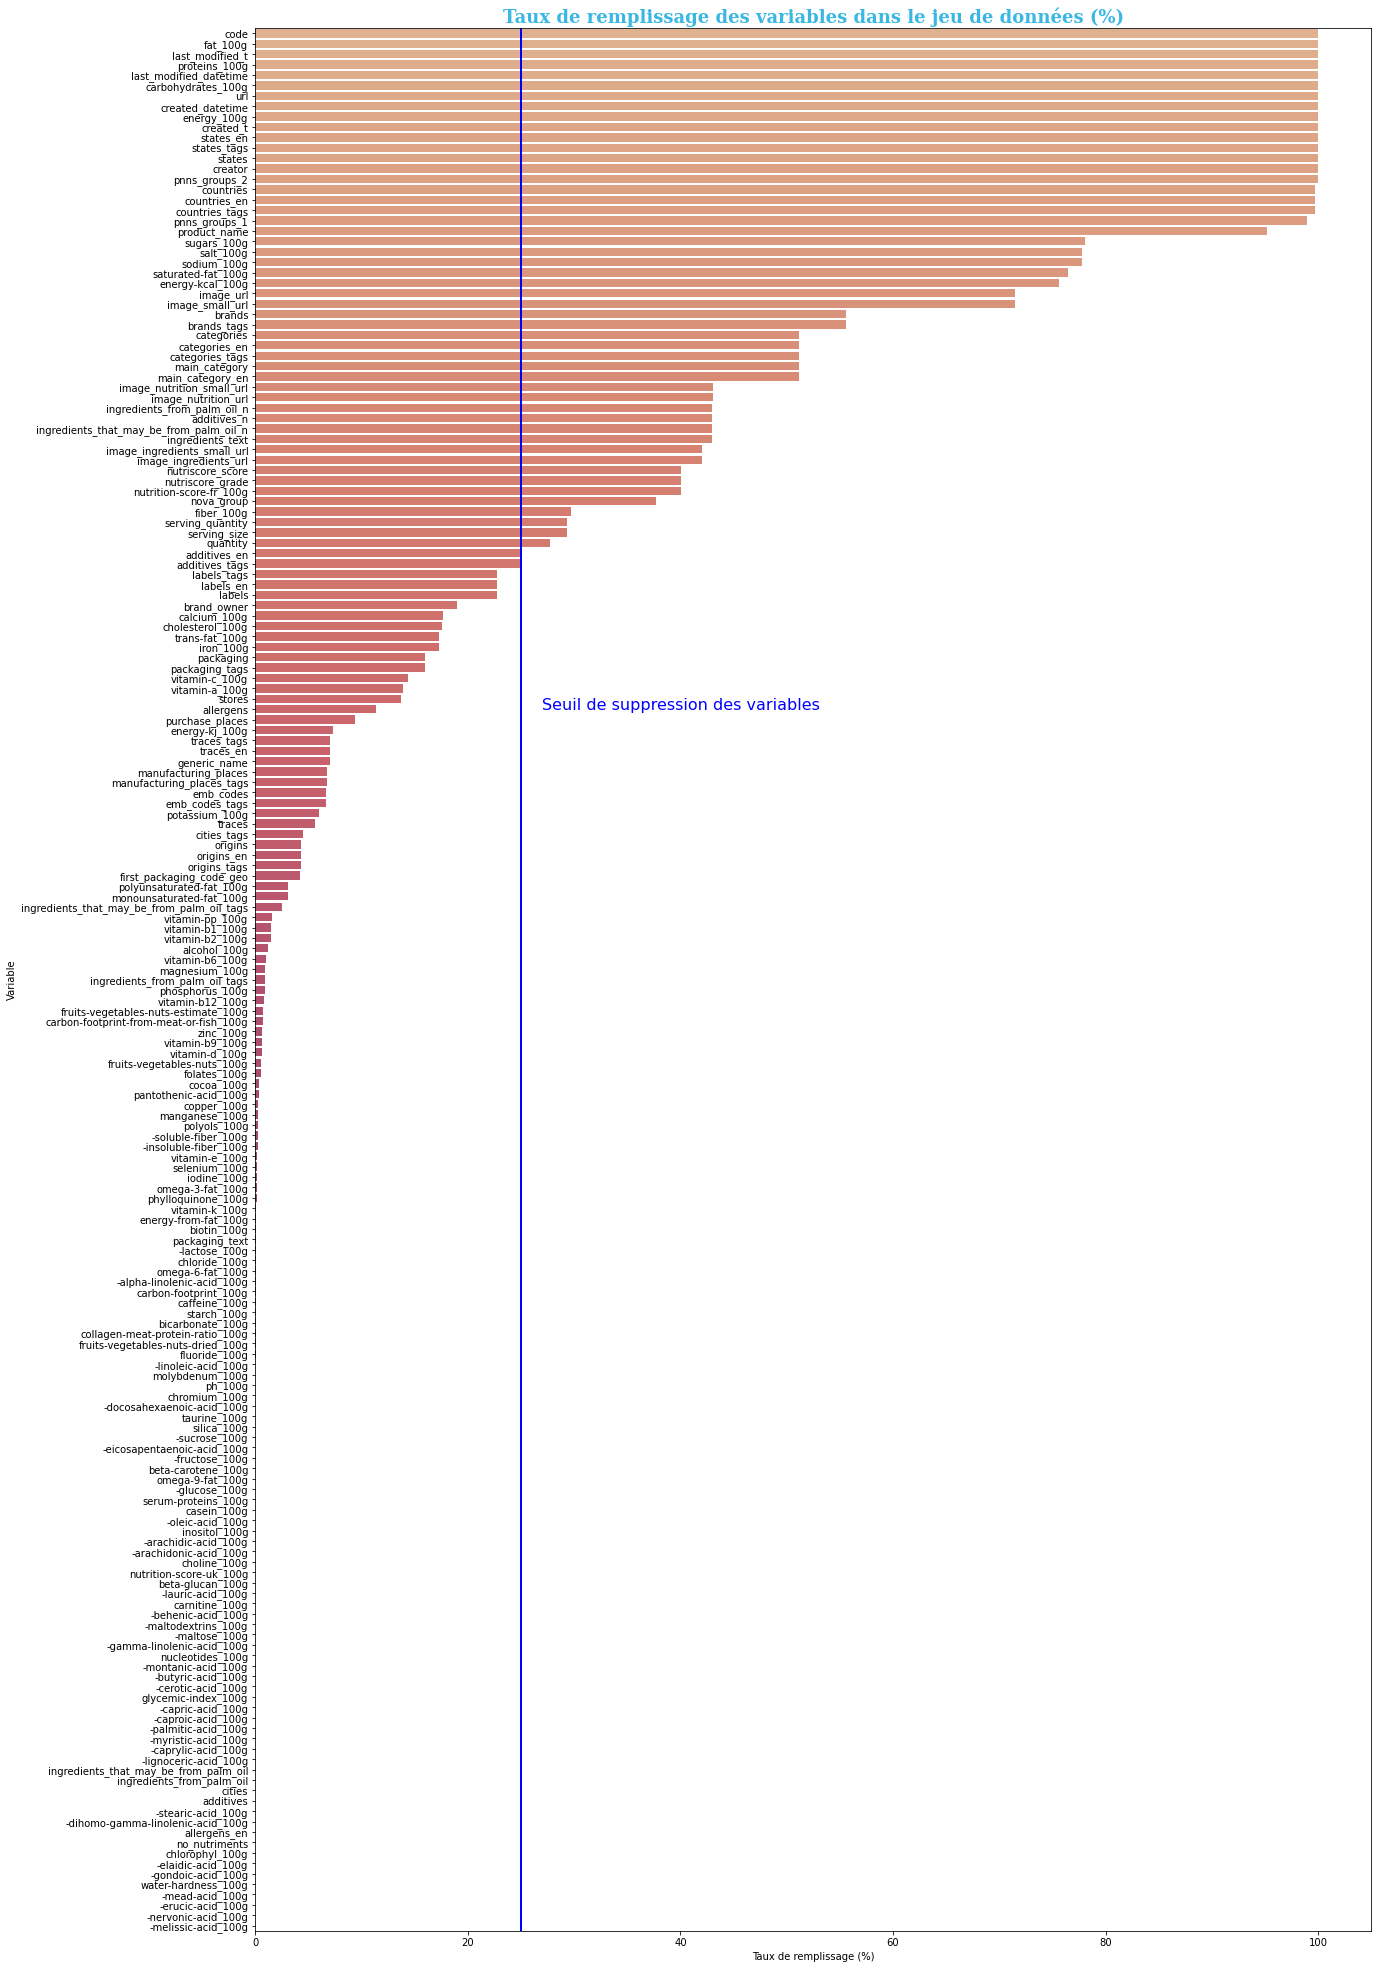

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

filling_features = null_factor(sampled_df, 0)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False) 

#Seuil de suppression
sup_threshold = 25

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#3BB7E3',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'b')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'b')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

In [26]:
#Liste des variables à conserver
features_to_conserve = list(filling_features.loc[filling_features['Taux_de_Null']>=sup_threshold, 'Variable'].values)
#Liste des variables supprimées
deleted_features = list(filling_features.loc[filling_features['Taux_de_Null']<sup_threshold, 'Variable'].values)

#Nouveau Dataset avec les variables conservées
sampled_df = sampled_df[features_to_conserve].sort_values(["created_datetime","last_modified_datetime"], ascending=True)
sampled_df.sample(5)

,code,fat_100g,last_modified_t,proteins_100g,last_modified_datetime,carbohydrates_100g,url,created_datetime,energy_100g,created_t,...,nutriscore_score,nutriscore_grade,nutrition-score-fr_100g,nova_group,fiber_100g,serving_quantity,serving_size,quantity,additives_en,additives_tags
376679,0810683022202,20.00,1587586570,6.67,2020-04-22T20:16:10Z,66.67,http://world-en.openfoodfacts.org/product/0810...,2017-03-09T15:37:27Z,1954.0,1489073847,...,NaN,NaN,NaN,4.0,6.7,15.0,15 g (15 g),NaN,"E322 - Lecithins,E322i - Lecithin,E331 - Sodiu...","en:e322,en:e322i,en:e331,en:e340,en:e340ii,en:..."
65716,0034952589849,3.12,1587666089,0.00,2020-04-23T18:21:29Z,84.38,http://world-en.openfoodfacts.org/product/0034...,2020-04-23T18:21:29Z,1569.0,1587666089,...,14.0,d,14.0,4.0,0.0,32.0,3 Tbsp (32 g),NaN,"E102 - Tartrazine,E110 - Sunset yellow FCF,E12...","en:e102,en:e110,en:e129,en:e132,en:e133,en:e15..."
403005,0853547003801,53.12,1587593169,21.88,2020-04-22T22:06:09Z,21.88,http://world-en.openfoodfacts.org/product/0853...,2017-03-09T21:08:02Z,2485.0,1489093682,...,5.0,c,5.0,2.0,9.4,32.0,1 PACK (32 g),NaN,NaN,NaN
818653,3564700641675,8.80,1600273186,5.60,2020-09-16T16:19:46Z,24.00,http://world-en.openfoodfacts.org/product/3564...,2017-03-09T18:45:40Z,843.0,1489085140,...,NaN,NaN,NaN,4.0,1.8,NaN,NaN,470 g,"E14XX - Modified Starch,E392 - Extracts of ros...","en:e14xx,en:e392,en:e450,en:e500"
473020,20808754,2.80,1547906120,5.50,2019-01-19T13:55:20Z,41.90,http://world-en.openfoodfacts.org/product/2080...,2019-01-19T13:55:17Z,962.0,1547906117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
def search_componant(sampled_df, suffix='_100g'):
  componant = []
  for col in sampled_df.columns:
      if '_100g' in col: componant.append(col)
  sampled_df_subset_columns = sampled_df[componant]
  return sampled_df_subset_columns

In [28]:
sampled_df_subset_nutients = search_componant(sampled_df,'_100g')
sampled_df_subset_nutients.head()

,fat_100g,proteins_100g,carbohydrates_100g,energy_100g,sugars_100g,salt_100g,sodium_100g,saturated-fat_100g,energy-kcal_100g,nutrition-score-fr_100g,fiber_100g
585317,36.0,8.1,49.0,2316.0,47.0,0.30000,0.120000,15.00,556.0,24.0,3.3
846276,37.9,10.9,2.9,1642.0,0.6,0.60000,0.240000,12.09,398.0,16.0,NaN
649849,22.0,21.0,0.5,1180.0,0.5,1.70000,0.680000,16.00,NaN,15.0,NaN
668870,0.1,0.6,10.5,184.0,9.2,0.00508,0.002032,0.05,NaN,4.0,0.5
822967,0.5,7.5,78.0,1480.0,0.0,0.00000,0.000000,0.00,NaN,-1.0,1.0


In [29]:
print('Lignes nutriments (_100g) vides: {}'.format(sampled_df_subset_nutients.isnull().all(axis=1).sum()))

Lignes nutriments (_100g) vides: 0


In [30]:
sampled_df = sampled_df[sampled_df_subset_nutients.notnull().any(axis=1)]
sampled_df.shape

(457374, 52)